# KOH-style calibration toy test in `rxmc`
We calibrate a **linear** physical model $f(x; m,b)=mx+b$ to synthetic data generated from a *slightly curved* truth:
$$y_{\text{true}}(x)=\frac{mx+b}{1+x/K}$$
We compare three likelihood/discrepancy choices:
1. `LikelihoodModel` (no additional model discrepancy)
2. `UnknownModelError` (uncorrelated fractional model error)
3. `SklearnKernelGPDiscrepancyModel` (correlated GP discrepancy via an sklearn kernel)

Sampling is done with **emcee** using `rxmc` objects for model/covariance/log-likelihood.

In [1]:
from collections import OrderedDict

import arviz as az
import emcee
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


## 1) Physical model (line)

In [2]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        return m * x + b


my_model = LinearModel()

## 2) Generate synthetic data (curved truth + iid noise)

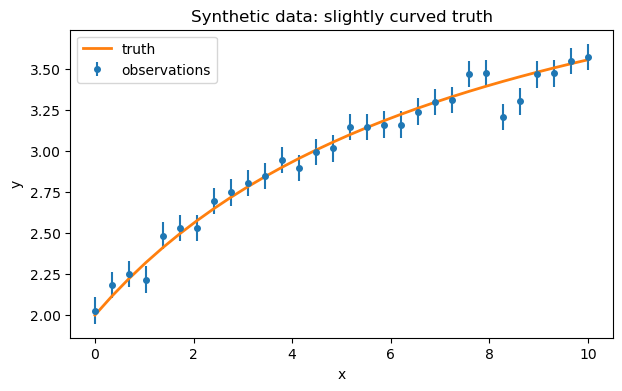

In [3]:
rng = np.random.default_rng(1)

# "true" linear parameters for numerator
m_true, b_true = 0.6, 2.0

# curvature scale: larger K => smaller deviation from best-fit line
K_true = 8.0

# domain
Xmax = 10.0
n = 30
x = np.linspace(0, Xmax, n)


def y_truth(x, m, b, K):
    return (m * x + b) / (1.0 + x / K)


sigma_obs = 0.08
y = y_truth(x, m_true, b_true, K_true)
y_obs = y + rng.normal(0.0, sigma_obs, size=n)
y_stat_err = sigma_obs * np.ones_like(y_obs)

obs = rxmc.observation.Observation(x=x, y=y_obs, y_stat_err=y_stat_err)

plt.figure(figsize=(7, 4))
plt.errorbar(x, y_obs, yerr=y_stat_err, fmt="o", ms=4, label="observations")
plt.plot(x, y, lw=2, label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Synthetic data: slightly curved truth")
plt.show()

## 3) Likelihood models
We’ll use:
- `LikelihoodModel()` (no discrepancy)
- `UnknownModelError()` (learns an uncorrelated fractional model error)
- `SklearnKernelGPDiscrepancyModel` implemented below (learns correlated GP discrepancy hyperparameters)

### 3.1 `SklearnKernelGPDiscrepancyModel`
This wraps an sklearn kernel and exposes its **free hyperparameters** (in sklearn's log-space `kernel.theta`) as `rxmc` likelihood parameters.

In [4]:
from rxmc.correlated_discrepancy_likelihood_model import SklearnKernelGPDiscrepancyModel

help(SklearnKernelGPDiscrepancyModel)

Help on class SklearnKernelGPDiscrepancyModel in module rxmc.correlated_discrepancy_likelihood_model:

class SklearnKernelGPDiscrepancyModel(rxmc.likelihood_model.ParametricLikelihoodModel)
 |  SklearnKernelGPDiscrepancyModel(
 |      kernel: sklearn.gaussian_process.kernels.Kernel,
 |      jitter: float = 1e-10,
 |      param_prefix: str = 'discrepancy_'
 |  )
 |
 |  GP discrepancy via an externally-defined sklearn Kernel object.
 |
 |  We infer the kernel's free hyperparameters by sampling kernel.theta
 |  (which sklearn stores in log-space for positive parameters).
 |
 |  covariance = observation.covariance(ym) + K_disc(x,x; kernel.theta) + jitter*I
 |
 |  Method resolution order:
 |      SklearnKernelGPDiscrepancyModel
 |      rxmc.likelihood_model.ParametricLikelihoodModel
 |      rxmc.likelihood_model.LikelihoodModel
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(
 |      self,
 |      kernel: sklearn.gaussian_process.kernels.Kernel,
 |      jitter: float = 

### 3.2 Instantiate the three likelihoods

In [5]:
like_std = rxmc.likelihood_model.LikelihoodModel()
like_unc = rxmc.likelihood_model.UnknownModelError()

# Choose a kernel for discrepancy: Constant * Matern(ν=2.5) + tiny white nugget
# (Matern is usually a better default than RBF for discrepancy; it avoids "infinitely smooth" bias.)
kernel = ConstantKernel(1.0) * Matern(length_scale=2.0, nu=2.5) + WhiteKernel(
    noise_level=1e-6
)
like_gp = SklearnKernelGPDiscrepancyModel(kernel=kernel, jitter=1e-10)

print("GP hyperparameter names (rxmc):", [p.name for p in like_gp.params])

GP hyperparameter names (rxmc): ['discrepancy__k1__k1__constant_value', 'discrepancy__k1__k2__length_scale', 'discrepancy__k2__noise_level']


## 4) Posterior sampling with emcee
We sample:
- Standard: `(m,b)`
- UnknownModelError: `(m,b, log_gamma)`
- GP discrepancy: `(m,b, kernel_theta...)`

Priors are simple and identical across models for `(m,b)`; likelihood hyperparameters get weakly-informative priors.

In [6]:
# Priors for the physical model parameters
def logprior_mb(m, b):
    return stats.norm.logpdf(m, 0.0, 2.0) + stats.norm.logpdf(b, 0.0, 5.0)


# Prior for log_gamma (fractional error): log_gamma ~ N(log(0.05), 1.0)
def logprior_loggamma(log_gamma):
    return stats.norm.logpdf(log_gamma, np.log(0.05), 1.0)


# Priors for sklearn kernel.theta (which is already log-space for positive params)
# We'll use broad normals centered around reasonable scales.
def logprior_kernel_theta(theta_vec):
    # You can tailor these once you see mixing / identifiability issues.
    # Here we just put N(0, 2) on each log-hyperparameter.
    theta_vec = np.asarray(theta_vec, float)
    return np.sum(stats.norm.logpdf(theta_vec, 0.0, 2.0))


def loglike_std(m, b):
    ym = my_model.y(x, m, b)
    return like_std.log_likelihood(obs, ym)


def loglike_unc(m, b, log_gamma):
    ym = my_model.y(x, m, b)
    return like_unc.log_likelihood(obs, ym, log_gamma)


def loglike_gp(m, b, theta_vec):
    ym = my_model.y(x, m, b)
    return like_gp.log_likelihood(obs, ym, *theta_vec)


def logpost_std(q):
    m, b = q
    lp = logprior_mb(m, b)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike_std(m, b)


def logpost_unc(q):
    m, b, log_gamma = q
    lp = logprior_mb(m, b) + logprior_loggamma(log_gamma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike_unc(m, b, log_gamma)


def logpost_gp(q):
    m, b = q[0], q[1]
    theta_vec = q[2:]
    lp = logprior_mb(m, b) + logprior_kernel_theta(theta_vec)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike_gp(m, b, theta_vec)

In [7]:
def run_emcee(logpost, ndim, nwalkers=32, nsteps=6000, burn=1000, thin=5, seed=0):
    rng = np.random.default_rng(seed)
    p0 = rng.normal(0.0, 0.1, size=(nwalkers, ndim))
    # crude init near a line fit
    p0[:, 0] += 0.5
    p0[:, 1] += 1.5

    sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)
    sampler.run_mcmc(p0, nsteps, progress=True)

    chain = sampler.get_chain(discard=burn, thin=thin, flat=True)
    logp = sampler.get_log_prob(discard=burn, thin=thin, flat=True)
    return chain, logp, sampler


chain_gp, logp_gp, sampler_gp = run_emcee(
    logpost_gp, ndim=2 + len(like_gp.params), seed=12
)
chain_std, logp_std, sampler_std = run_emcee(logpost_std, ndim=2, seed=10)
chain_unc, logp_unc, sampler_unc = run_emcee(logpost_unc, ndim=3, seed=11)

print(chain_std.shape, chain_unc.shape, chain_gp.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [05:07<00:00, 19.54it/s]

(32000, 2) (32000, 3) (32000, 5)


### Posterior summaries

In [8]:
def summarize_chain(chain, names):
    import pandas as pd

    q = np.quantile(chain, [0.05, 0.5, 0.95], axis=0)
    return pd.DataFrame(q, index=["p05", "p50", "p95"], columns=names)


names_std = ["m", "b"]
names_unc = ["m", "b", "log_gamma"]
names_gp = ["m", "b"] + [p.name for p in like_gp.params]

print("Truth: m =", m_true, "b =", b_true, "(K_true =", K_true, ")\n")
print("Standard likelihood:\n", summarize_chain(chain_std, names_std), "\n")
print("UnknownModelError:\n", summarize_chain(chain_unc, names_unc), "\n")
print("GP discrepancy:\n", summarize_chain(chain_gp, names_gp), "\n")

Truth: m = 0.6 b = 2.0 (K_true = 8.0 )

Standard likelihood:
             m         b
p05  0.132780  2.219639
p50  0.140844  2.266864
p95  0.148955  2.313466 

UnknownModelError:
             m         b  log_gamma
p05  0.133130  2.178105  -4.083681
p50  0.144833  2.245603  -3.550750
p95  0.157366  2.310559  -3.153068 

GP discrepancy:
             m         b  discrepancy__k1__k1__constant_value  \
p05  0.026775 -1.063407                            -3.187007   
p50  0.166168  1.827181                            -0.362130   
p95  0.331447  3.280644                             2.526725   

     discrepancy__k1__k2__length_scale  discrepancy__k2__noise_level  
p05                           1.250007                     -7.751879  
p50                           2.376248                     -6.245652  
p95                           3.288551                     -5.122636   



## 5) Predictive posteriors
We compare posterior predictive bands on a dense grid.

- **Standard**: predictive is line + observational noise
- **UnknownModelError**: add uncorrelated model error variance $(\gamma f)^2$
- **GP discrepancy**: compute GP posterior for discrepancy given residuals, then sample discrepancy on the grid

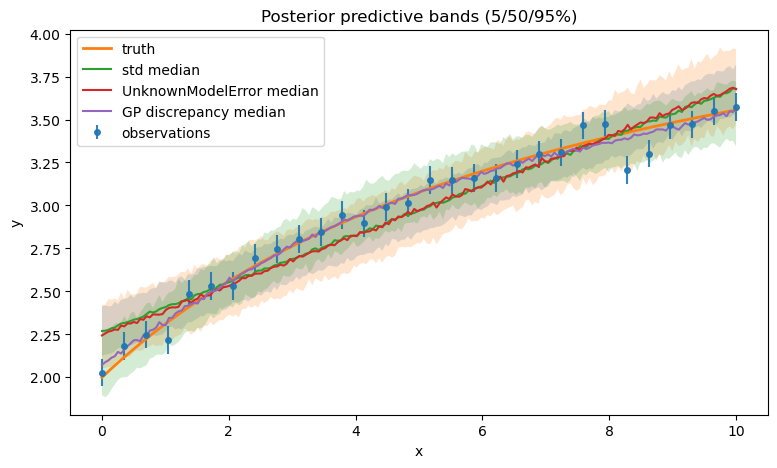

In [9]:
xg = np.linspace(0, Xmax, 200)


def pred_std(samples, n_draws=300):
    idx = np.random.default_rng(0).choice(samples.shape[0], size=n_draws, replace=False)
    ys = []
    for i in idx:
        m, b = samples[i]
        mu = my_model.y(xg, m, b)
        ys.append(mu + np.random.normal(0.0, sigma_obs, size=len(xg)))
    return np.array(ys)


def pred_unc(samples, n_draws=300):
    idx = np.random.default_rng(1).choice(samples.shape[0], size=n_draws, replace=False)
    ys = []
    for i in idx:
        m, b, log_gamma = samples[i]
        gamma = np.exp(log_gamma)
        mu = my_model.y(xg, m, b)
        # total pointwise std: obs noise + model frac error
        std = np.sqrt(sigma_obs**2 + (gamma * mu) ** 2)
        ys.append(mu + np.random.normal(0.0, std, size=len(xg)))
    return np.array(ys)


def kernel_matrix_from_theta(kernel, X, theta):
    k = kernel.clone_with_theta(np.asarray(theta, float))
    return k(X)


def pred_gp(samples, n_draws=200):
    rng = np.random.default_rng(2)
    idx = rng.choice(samples.shape[0], size=n_draws, replace=False)

    Xtrain = x[:, None]
    Xg = xg[:, None]
    ys = []

    for i in idx:
        m, b = samples[i, 0], samples[i, 1]
        theta_vec = samples[i, 2:]

        mu_train = my_model.y(x, m, b)
        r = y_obs - mu_train

        # GP discrepancy prior covariances
        Ktt = kernel_matrix_from_theta(kernel, Xtrain, theta_vec)
        Kss = kernel_matrix_from_theta(kernel, Xg, theta_vec)
        Kst = kernel.clone_with_theta(theta_vec)(Xg, Xtrain)  # cross-cov

        # total training covariance includes observational noise
        Ktrain = Ktt + (sigma_obs**2) * np.eye(n)

        # solve for posterior mean/cov of discrepancy at grid
        L = np.linalg.cholesky(Ktrain + 1e-10 * np.eye(n))
        # alpha = Ktrain^{-1} r via two triangular solves
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, r))

        disc_mean = Kst @ alpha

        # posterior covariance: Kss - Kst Ktrain^{-1} Kts
        v = np.linalg.solve(L, Kst.T)
        disc_cov = Kss - v.T @ v
        disc_var = np.clip(np.diag(disc_cov), 0.0, np.inf)

        mu = my_model.y(xg, m, b) + disc_mean
        ys.append(mu + rng.normal(0.0, np.sqrt(disc_var + sigma_obs**2), size=len(xg)))

    return np.array(ys)


Y_std = pred_std(chain_std)
Y_unc = pred_unc(chain_unc)
Y_gp = pred_gp(chain_gp)


def band(Y):
    lo, md, hi = np.percentile(Y, [5, 50, 95], axis=0)
    return lo, md, hi


lo_s, md_s, hi_s = band(Y_std)
lo_u, md_u, hi_u = band(Y_unc)
lo_g, md_g, hi_g = band(Y_gp)

plt.figure(figsize=(9, 5))
plt.errorbar(x, y_obs, yerr=y_stat_err, fmt="o", ms=4, label="observations", alpha=0.9)
plt.plot(xg, y_truth(xg, m_true, b_true, K_true), lw=2, label="truth")

plt.plot(xg, md_s, label="std median")
plt.fill_between(xg, lo_s, hi_s, alpha=0.2)

plt.plot(xg, md_u, label="UnknownModelError median")
plt.fill_between(xg, lo_u, hi_u, alpha=0.2)

plt.plot(xg, md_g, label="GP discrepancy median")
plt.fill_between(xg, lo_g, hi_g, alpha=0.2)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Posterior predictive bands (5/50/95%)")
plt.show()

## 6) Posterior comparison plots

/home/kyle/mambaforge/envs/pymc_env/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(
/home/kyle/mambaforge/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/kyle/mambaforge/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/density_utils.py:826: RuntimeWarning: invalid value encountered in divide
  xyi /= [d_x, d_y]
/home/kyle/mambaforge/envs/pymc_env/lib/python3.13/site-packages/arviz/stats/density_utils.py:830: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _cov(xyi)
/home/kyle/mambaforge/envs/pymc_env/lib/python3.13/site-packages/arviz/utils.py:441: RuntimeWarning: divide by zero encountered in

ValueError: arange: cannot compute length

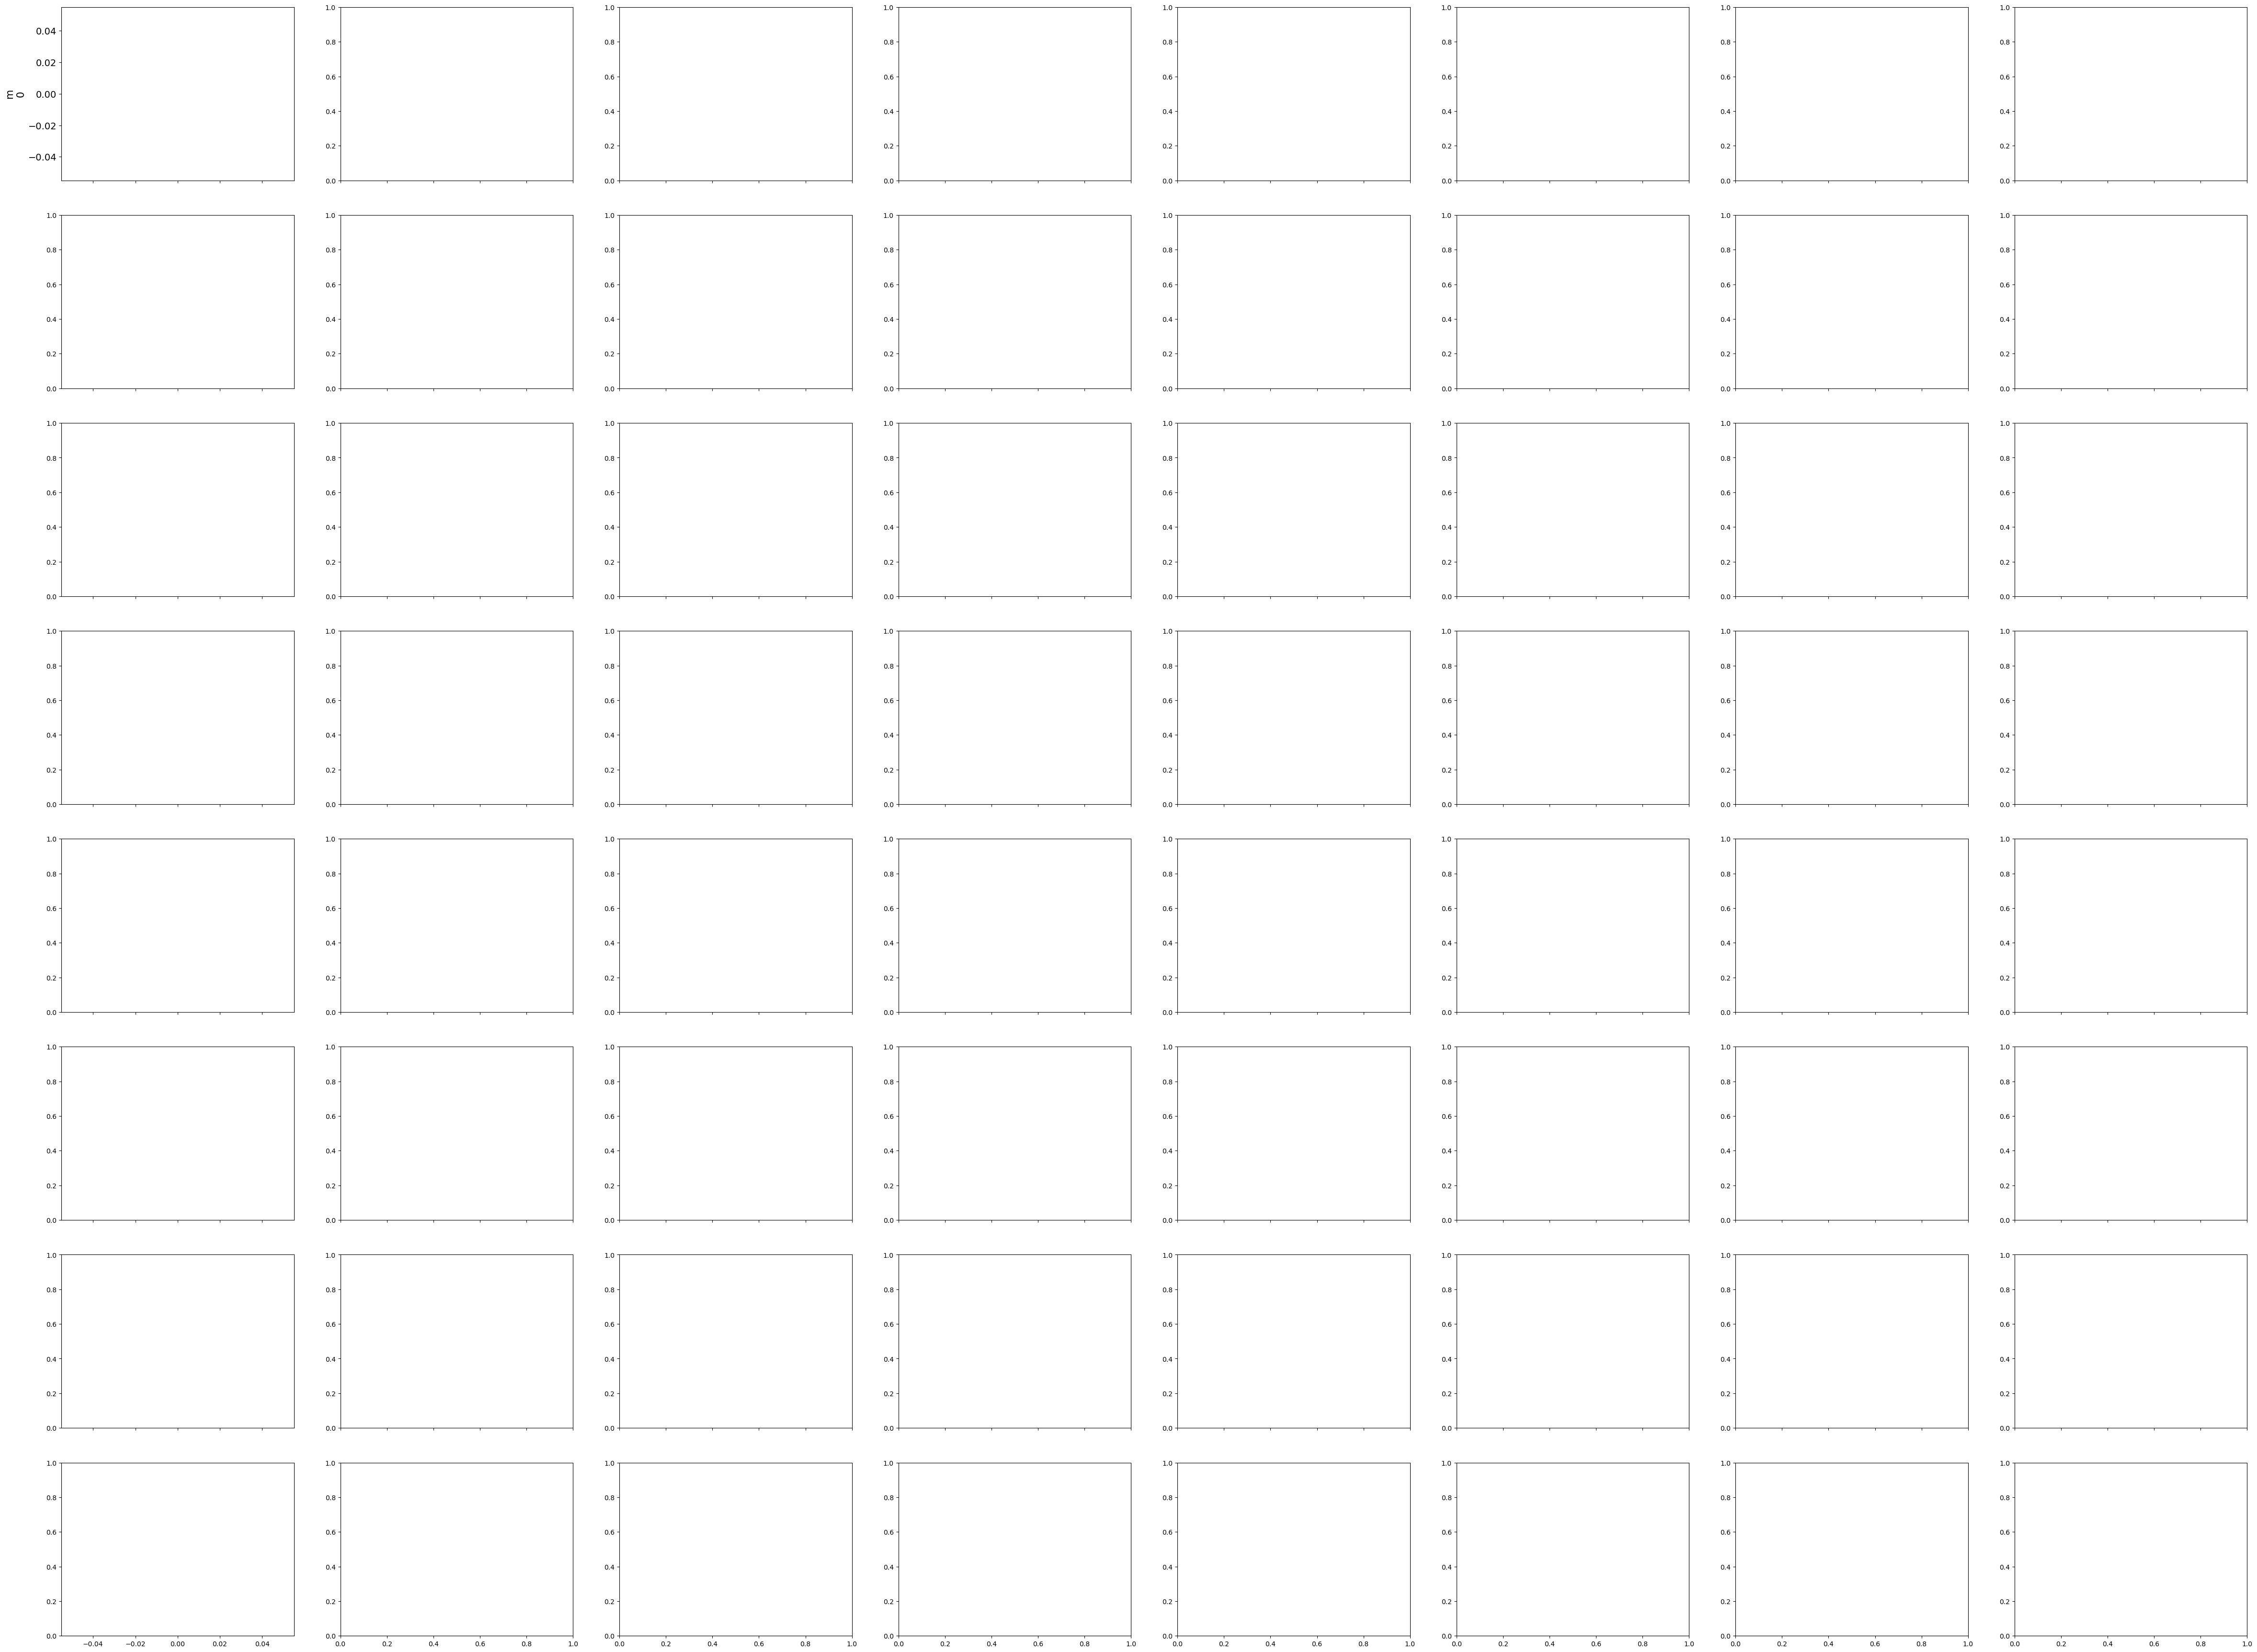

In [10]:
import pandas as pd


def corner_like(chain, names, title):
    idata = az.from_dict(
        posterior={n: chain[:, i][None, None, :] for i, n in enumerate(names)}
    )
    az.plot_pair(idata, var_names=names, kind="kde", marginals=True)
    plt.suptitle(title)
    plt.show()


corner_like(chain_std[:, :2], ["m", "b"], "Posterior: standard LikelihoodModel")
corner_like(chain_unc[:, :2], ["m", "b"], "Posterior: UnknownModelError (m,b shown)")
corner_like(chain_gp[:, :2], ["m", "b"], "Posterior: GP discrepancy (m,b shown)")